# Image classification

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Explore the dataset

In [2]:
# import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir)
project_path = 'F:\projects\security-system'
data_dir = rf'{project_path}/object_dataset'

## Create a dataset

Define some parameters for the loader:

In [3]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 230 files belonging to 3 classes.
Using 184 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 230 files belonging to 3 classes.
Using 46 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [6]:
class_names = train_ds.class_names
print(class_names)

['camera_interference', 'object_absent', 'object_present']


## Visualize the data

Here are the first 9 images from the training dataset.

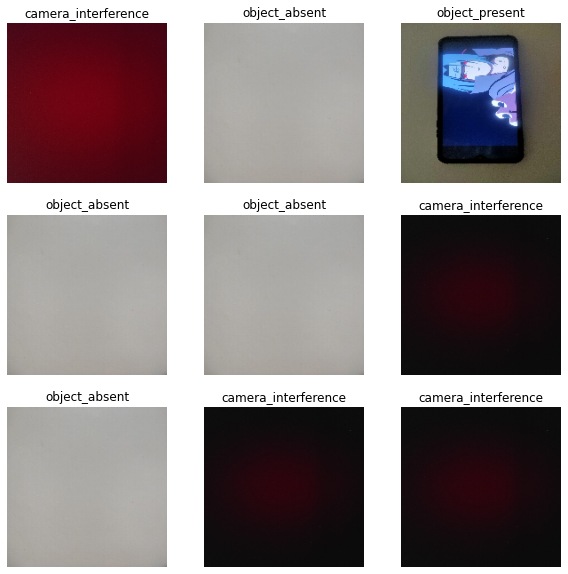

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.013291935 0.5786275


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [12]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 15s 3s/step - loss: 0.9797 - accuracy: 0.4860 - val_loss: 0.0643 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 5s 830ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 2.4504e-05 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 5s 858ms/step - loss: 3.6112e-05 - accuracy: 1.0000 - val_loss: 1.0868e-04 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 5s 898ms/step - loss: 6.1864e-05 - accuracy: 1.0000 - val_loss: 2.3324e-07 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 5s 943ms/step - loss: 1.4645e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 6s 903ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 6s 963ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 -

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

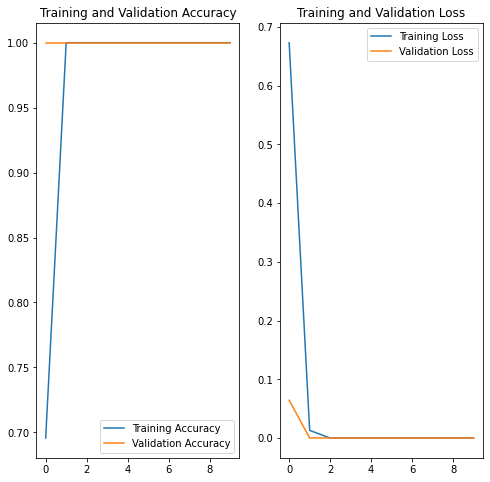

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

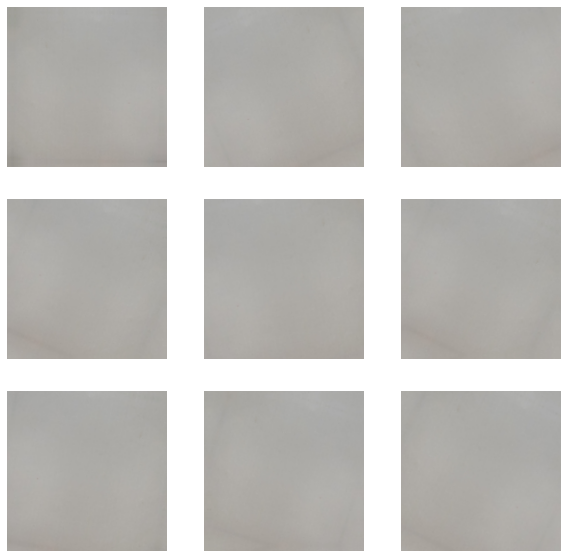

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [19]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
6/6 [==============================] - 8s 1s/step - loss: 1.1449 - accuracy: 0.4584 - val_loss: 0.3524 - val_accuracy: 1.0000
Epoch 2/15
6/6 [==============================] - 6s 1s/step - loss: 0.2071 - accuracy: 0.9882 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/15
6/6 [==============================] - 6s 1s/step - loss: 9.0809e-04 - accuracy: 1.0000 - val_loss: 1.4564e-06 - val_accuracy: 1.0000
Epoch 4/15
6/6 [==============================] - 6s 1s/step - loss: 3.2001e-06 - accuracy: 1.0000 - val_loss: 2.1649e-05 - val_accuracy: 1.0000
Epoch 5/15
6/6 [==============================] - 6s 1s/step - loss: 2.1231e-05 - accuracy: 1.0000 - val_loss: 3.6851e-06 - val_accuracy: 1.0000
Epoch 6/15
6/6 [==============================] - 6s 1s/step - loss: 1.9534e-06 - accuracy: 1.0000 - val_loss: 9.3294e-08 - val_accuracy: 1.0000
Epoch 7/15
6/6 [==============================] - 6s 1s/step - loss: 5.8284e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
E

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

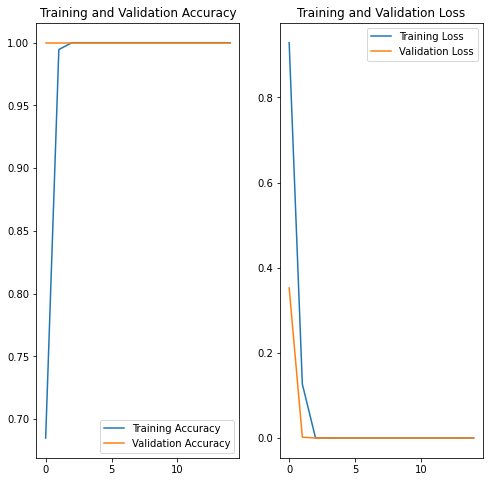

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Export your model

In [24]:
import time
t = time.time()

export_path = "saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: saved_models/1617258191\assets


'saved_models/1617258191'

In [25]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()

0.0